# Analysing the Bird Species Predictions from AI4Earth
## By Emma Vriezen | Created on: 2021-01-18 | Last edit on: 2021-01-24

In [24]:
# Imports:
import re  # Regular expressions
import time  # For waiting between API requests
import pandas as pd  # DataFrames
import numpy as np  # Calculating stuff
import networkx as nx  # Making networks
import requests as rq  # Send HTTP requests to servers
import matplotlib.pyplot as plt  # For plotting
from scipy import stats  # For the linear regression
from IPython.core.display import HTML
from pyvis.network import Network  # for making a graph


In [2]:
# Import the list:
pred_path = r"C:\Users\emmav\Documents\AI Master year 1\TMM\Project\PredictedSpecies.txt"
pred_df = pd.read_csv(pred_path, header=0)
pred_df.dropna(inplace=True)  # Remove the rows that failed
nr_of_preds = len(pred_df.index)
pred_df.head()


,ID,Scientific,ScientificPred0,CommonPred0,ProbPred0,ScientificPred1,CommonPred1,ProbPred1,ScientificPred2,CommonPred2,ProbPred2,ScientificPred3,CommonPred3,ProbPred3,ScientificPred4,CommonPred4,ProbPred4
0,9/32670539,Tachybaptus ruficollis,Tachybaptus ruficollis,Little Grebe,83.45,Tachybaptus dominicus,Least Grebe,7.72,Podilymbus podiceps,Pied billed Grebe,2.43,Podiceps nigricollis,Eared Grebe,0.58,Podiceps grisegena,Red necked Grebe,0.33
1,8/32664908,Tachybaptus ruficollis,Tachybaptus ruficollis,Little Grebe,33.66,Tachybaptus dominicus,Least Grebe,22.29,Podilymbus podiceps,Pied billed Grebe,6.48,Cerorhinca monocerata,Rhinoceros Auklet,4.51,Podiceps grisegena,Red necked Grebe,3.34
2,0/32663960,Tachybaptus ruficollis,Oxyura jamaicensis,Ruddy Duck,30.35,Tachybaptus ruficollis,Little Grebe,10.59,Aythya valisineria,Canvasback,10.18,Podilymbus podiceps,Pied billed Grebe,5.85,Aythya collaris,Ring necked Duck,4.96
3,8/32662888,Tachybaptus ruficollis,Podiceps grisegena,Red necked Grebe,46.92,Podiceps auritus,Horned Grebe,15.37,Tachybaptus ruficollis,Little Grebe,9.70,Podiceps nigricollis,Eared Grebe,6.94,Podiceps cristatus,Great Crested Grebe,6.75
4,3/32660353,Tachybaptus ruficollis,Oxyura jamaicensis,Ruddy Duck,27.90,Aythya americana,Redhead,20.17,Aythya affinis,Lesser Scaup,10.83,Aythya novaeseelandiae,New Zealand Scaup,7.87,Aythya collaris,Ring necked Duck,5.71


In [3]:
# Calculate accuracy with first prediction:
pred_df['FirstCorrect'] = np.where(pred_df['Scientific'] == pred_df['ScientificPred0'], True, False)
accuracy = pred_df['FirstCorrect'].sum()/nr_of_preds * 100
print("Accuracy:", accuracy)

# Calculate accuracy with somewhere in the top 5 of predictions:
pred_df['InTopFive'] = np.where((pred_df['Scientific'] == pred_df['ScientificPred0']) |
                                (pred_df['Scientific'] == pred_df['ScientificPred1']) |
                                (pred_df['Scientific'] == pred_df['ScientificPred2']) |
                                (pred_df['Scientific'] == pred_df['ScientificPred3']) |
                                (pred_df['Scientific'] == pred_df['ScientificPred4']), True, False)
top_five_accuracy = pred_df['InTopFive'].sum()/nr_of_preds * 100
print("Within top 5 accuracy:", top_five_accuracy)

pred_df.index

Accuracy: 68.60170467634185
Within top 5 accuracy: 87.46832527067497


Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4334, 4335, 4336, 4337, 4338, 4339, 4340, 4341, 4342, 4343],
           dtype='int64', length=4341)

In [4]:
# We will create a graph of the birds, with edges between species and their wrong predictions.
# So we have to find the pairs of "species - wrong prediction", and all species for the nodes.
edges = pred_df.groupby(['Scientific','ScientificPred0']).size().reset_index().rename(columns={0:'Count'})
edges = edges[edges.ScientificPred0.isin(edges['Scientific'])]  # Only pair of Dutch birds
nodes = edges['Scientific'].unique()
assert len(nodes) == 181  # There are 181 species
assert len(edges[edges['Scientific']==edges['ScientificPred0']]) == 181  # There are no species with 0% accurate predictions

# List with 24 colours indicating how often the species was correctly classified:
colours = ['#00ff00', '#16ff00', '#2cff00', '#42ff00', 
           '#58ff00', '#6eff00', '#85ff00', '#9bff00', 
           '#b1ff00', '#c7ff00', '#ddff00', '#f3ff00', 
           '#fff300', '#ffdd00', '#ffc700', '#ffb100', 
           '#ff9b00', '#ff8500', '#ff6e00', '#ff5800', 
           '#ff4200', '#ff2c00', '#ff1600', '#ff0000'
          ]  # Gradient from http://www.perbang.dk/rgbgradient/
colours.reverse()

counts = edges[edges['Scientific']==edges['ScientificPred0']].Count
node_colours = [colours[count-1] for count in counts]
counts = counts.astype('str').tolist()


In [38]:
# Make the graph:
net = Network(directed=True)
node_ids = range(len(nodes))  # Can be used as first argument in .add_nodes
net.add_nodes(nodes, title=counts, label=nodes, color=node_colours)

for edge in zip(edges['Scientific'], edges['ScientificPred0'], edges['Count']):
    (src, dst, w) = edge
    if src != dst:  # Do not add reflective edges
        if w != 1:
            title = src + " as " + dst + ":<br>" + str(w) + " times"
        else:
            title = src + " as " + dst + ":<br>" + str(w) + " time"
        net.add_edge(source=src, to=dst, value=w, arrowStrikethrough=False, title=title)

neighbor_map = net.get_adj_list()
for node in net.nodes:
    if len(neighbor_map[node["id"]]) > 0:
        node["title"] = node["id"] + "<br>Correct: " + node["title"] + "<br>Wrong:"
        for neighbor in neighbor_map[node["id"]]:
            nr = edges[(edges['Scientific']==node["id"]) & (edges['ScientificPred0']==neighbor)]["Count"].iloc[0]
            node["title"] += "<br>- " + neighbor + " (" + str(nr) + ")"
    else:
        node["title"] = node["id"] + "<br>Correct: " + node["title"]
net.set_options("""
var options = {
  "physics": {
    "forceAtlas2Based": {
      "gravitationalConstant": -96,
      "springLength": 20,
      "springConstant": 0.01,
      "damping": 0.2,
      "avoidOverlap": 0.39
    },
    "minVelocity": 0.75,
    "solver": "forceAtlas2Based"
  }
}
"""
)
# net.show_buttons(filter_=['physics'])
# net.save_graph("BirdSpeciesNetwork.html")
net.show("graph.html")


Now, structure the graph according to their taxonomy. So for example, birds from the same family are grouped together visually.

In [6]:
# Import the list again:
tax_path = r"C:\Users\emmav\Documents\AI Master year 1\TMM\Project\BirdTaxonomy.txt"
tax_df = pd.read_csv(tax_path, header=0)
print("Number of orders:", len(tax_df['Order'].unique()))
print("Number of families:", len(tax_df['Family'].unique()))
tax_df.head()


Number of orders: 22
Number of families: 54


,Scientific,Order,Family
0,Acanthis flammea,Passeriformes,Fringillidae
1,Accipiter gentilis,Accipitriformes,Accipitridae
2,Accipiter nisus,Accipitriformes,Accipitridae
3,Actitis hypoleucos,Charadriiformes,Scolopacidae
4,Aegithalos caudatus,Passeriformes,Aegithalidae


In [7]:
pred_combos = edges.reset_index(drop=True)

families = []
families_pred = []
orders = []
orders_pred = []

for row_n in range(len(pred_combos.index)):
    real = pred_combos['Scientific'][row_n]
    pred = pred_combos['ScientificPred0'][row_n]
    families.append(tax_df[tax_df['Scientific']==real]['Family'].values[0])
    families_pred.append(tax_df[tax_df['Scientific']==pred]['Family'].values[0])
    orders.append(tax_df[tax_df['Scientific']==real]['Order'].values[0])
    orders_pred.append(tax_df[tax_df['Scientific']==pred]['Order'].values[0])

pred_combos['Family'] = families
pred_combos['FamilyPred0'] = families_pred
pred_combos['Order'] = orders
pred_combos['OrderPred0'] = orders_pred

pred_combos.head()


,Scientific,ScientificPred0,Count,Family,FamilyPred0,Order,OrderPred0
0,Acanthis flammea,Acanthis flammea,15,Fringillidae,Fringillidae,Passeriformes,Passeriformes
1,Acanthis flammea,Carduelis carduelis,1,Fringillidae,Fringillidae,Passeriformes,Passeriformes
2,Acanthis flammea,Falco tinnunculus,1,Fringillidae,Falconidae,Passeriformes,Falconiformes
3,Acanthis flammea,Fringilla montifringilla,1,Fringillidae,Fringillidae,Passeriformes,Passeriformes
4,Acanthis flammea,Phylloscopus collybita,1,Fringillidae,Phylloscopidae,Passeriformes,Passeriformes


In [8]:
fam_edges = pred_combos.groupby(['Family', 'FamilyPred0']).sum().reset_index()
print(fam_edges.head())

fam_nodes = fam_edges['Family'].unique()
assert len(fam_nodes) == 54  # There are 181 species

fam_counts = fam_edges[fam_edges['Family']==fam_edges['FamilyPred0']].Count
# node_colours = [colours[count-1] for count in counts]  # Not correct because not enough colours for families
fam_counts = fam_counts.astype('str').tolist()

# Make the graph:
net = Network(directed=True)
node_ids = range(len(fam_nodes))  # Can be used as first argument in .add_nodes
net.add_nodes(fam_nodes, title=fam_counts, label=fam_nodes)  #, color=node_colours)

for edge in zip(fam_edges['Family'], fam_edges['FamilyPred0'], fam_edges['Count']):
    (src, dst, w) = edge
    if src != dst:  # Do not add reflective edges
        net.add_edge(source=src, to=dst, value=w, arrowStrikethrough=False, title=str(w))
        
net.set_options("""
var options = {
  "physics": {
    "forceAtlas2Based": {
      "gravitationalConstant": -96,
      "springLength": 20,
      "springConstant": 0.01,
      "damping": 0.2,
      "avoidOverlap": 0.39
    },
    "minVelocity": 0.75,
    "solver": "forceAtlas2Based"
  }
}
"""
)
net.show("graph.html")


         Family   FamilyPred0  Count
0  Accipitridae  Accipitridae    158
1  Accipitridae      Anatidae      1
2  Accipitridae    Falconidae      3
3  Accipitridae       Laridae      1
4  Accipitridae     Tytonidae      1


### Rank species by accuracy and look at their rarity
It is difficult to interpret the network graphs without images as nodes that tell something about the looks of the birds, or without any taxonomic structuring. So we will move on from networks and try something else. We will order the birds by prediction accuracy from the Species Classifier API, and then look at if there is a relation between the rarity of the species and their prediction accuracy. The rarity will be taken from Waarneming.nl and reflects the rarity for a species in the Netherlands.

In [10]:
# Import the list that contains the IDs of the birds.
# The IDs are needed to requests the webpage for every bird species that contains the rarity information.
species_ids_path = r"C:\Users\emmav\Documents\AI Master year 1\TMM\Project\BirdsForClassification.txt"
species_ids = pd.read_csv(species_ids_path, header=0)
species_ids.head()


,Species,Scientific,ID
0,Dodaars,Tachybaptus ruficollis,2
1,Fuut,Podiceps cristatus,91
2,Roodhalsfuut,Podiceps grisegena,367
3,Geoorde Fuut,Podiceps nigricollis,3
4,Aalscholver,Phalacrocorax carbo,58


In [11]:
# Find the accuracy for each of the species, with Accuracy = True / True + False
pred_correct = pred_df.groupby(['Scientific', 'FirstCorrect']).size()
pred_correct_total = pred_correct.groupby(['Scientific']).sum()
pred_correct_true = pred_correct.xs(True, level='FirstCorrect')

pred_accuracies = (pred_correct_true / pred_correct_total).round(2).to_frame('Accuracy')
pred_accuracies.head()


,Accuracy
Scientific,
Acanthis flammea,0.62
Accipiter gentilis,0.25
Accipiter nisus,0.71
Actitis hypoleucos,0.83
Aegithalos caudatus,1.00


In [20]:
acc_path = r"C:\Users\emmav\Documents\AI Master year 1\TMM\Project\Accuracies.txt"
acc_df = pd.read_csv(acc_path, header=0, index_col=0)
acc_df.head()


,Accuracy,Rarity,Observations,Individuals
Scientific,,,,
Acanthis flammea,0.62,quite common,26064,372479
Accipiter gentilis,0.25,quite common,239254,258425
Accipiter nisus,0.71,common,375564,429298
Actitis hypoleucos,0.83,quite common,236519,533606
Aegithalos caudatus,1.00,common,286293,1205231


C:\Users\emmav\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


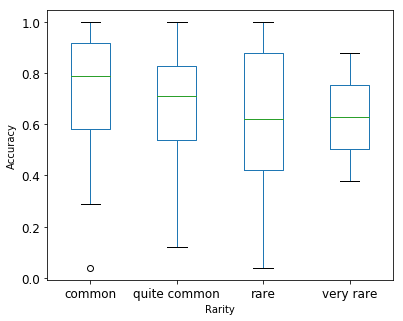

Linear regresion Accuracy/Individuals. R-squared = 0.006631097194604122 and p = 0.2758143533923412


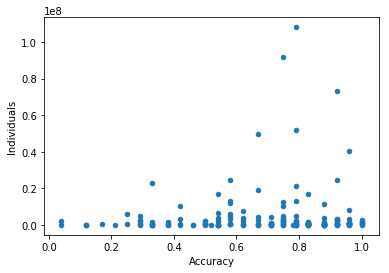

Linear regresion Accuracy/Observations. R-squared = 0.05065006825357865 and p = 0.0023189869113622655


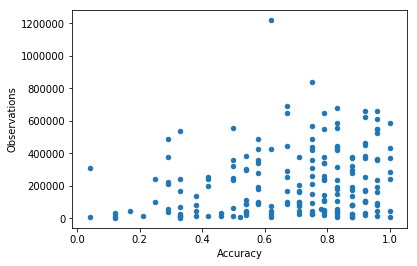

In [36]:
acc_df.boxplot(column='Accuracy', by='Rarity', grid=False, figsize=(6,5), fontsize=12)
plt.ylabel('Accuracy')
plt.title('')
plt.suptitle('')
plt.savefig('Acc-rare.svg', bbox_inches='tight')
plt.show()

acc_df.plot.scatter(x='Accuracy', y='Individuals')
lin_reg_1 = stats.linregress(x=acc_df['Accuracy'], y=acc_df['Individuals'])
print("Linear regresion Accuracy/Individuals. R-squared =", lin_reg_1.rvalue**2, "and p =", lin_reg_1.pvalue)
plt.savefig('Acc-Indv.svg', bbox_inches='tight')
plt.show()

acc_df.plot.scatter(x='Accuracy', y='Observations')
lin_reg_2 = stats.linregress(x=acc_df['Accuracy'], y=acc_df['Observations'])
print("Linear regresion Accuracy/Observations. R-squared =", lin_reg_2.rvalue**2, "and p =", lin_reg_2.pvalue)
plt.savefig('Acc-Obs.svg', bbox_inches='tight')
plt.show()
